In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
import json
import numpy as np
import os
import cv2
import pandas as pd

# COCO limb sequence (0-based indexing)
coco_limb_sequence = [
    (0, 1),  # Nose to Left Eye
    (0, 2),  # Nose to Right Eye
    (1, 3),  # Left Eye to Left Ear
    (2, 4),  # Right Eye to Right Ear
    (5, 7),  # Left Shoulder to Left Elbow
    (7, 9),  # Left Elbow to Left Wrist
    (6, 8),  # Right Shoulder to Right Elbow
    (8, 10), # Right Elbow to Right Wrist
    (5, 6),  # Left Shoulder to Right Shoulder
    (5, 11), # Left Shoulder to Left Hip
    (6, 12), # Right Shoulder to Right Hip
    (11, 12),# Left Hip to Right Hip
    (11, 13),# Left Hip to Left Knee
    (13, 15),# Left Knee to Left Ankle
    (12, 14),# Right Hip to Right Knee
    (14, 16) # Right Knee to Right Ankle
]

limb_sequence = [
    (0,15),
    (0,16),
    (15,16),
    (15,17),
    (16,18),
    (1,2),
    (2,3),
    (3,4),
    (1,5),
    (5,6),
    (6,7),
    (2,9),
    (5,12),
    (8,9),
    (9,10),
    (10,11),
    (8,12),
    (12,13),
    (13,14)
    ]

mapping = {0:0,1:15,2:16,3:17,4:18,5:2,6:5,7:3,8:6,9:4,10:7,11:9,12:12,13:10,14:13,15:11,16:14}

# COCO part list
part_list = {
    0: "Nose",
    1: "Left Eye",
    2: "Right Eye",
    3: "Left Ear",
    4: "Right Ear",
    5: "Left Shoulder",
    6: "Right Shoulder",
    7: "Left Elbow",
    8: "Right Elbow",
    9: "Left Wrist",
    10: "Right Wrist",
    11: "Left Hip",
    12: "Right Hip",
    13: "Left Knee",
    14: "Right Knee",
    15: "Left Ankle",
    16: "Right Ankle"
}


colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0],
          [0, 255, 0], \
          [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255],
          [85, 0, 255], \
          [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85],[255, 0, 0]]

In [2]:
def analyze_file(file_path, threshold=0.8):
    with open(file_path, 'r') as file:
        data = json.load(file)
    
    results = []
    for frame in data:
        frame_id = frame['frame_id']
        if frame['instances']:  # Ensure there is at least one detection
            first_instance = frame['instances'][0]
            keypoint_scores = first_instance['keypoint_scores']
            
            if len(keypoint_scores) != 17:
                continue
            
            all_above_thr = all(score > threshold for score in keypoint_scores)
            results.append({
                'frame_id': frame_id,
                'first_detection_keypoints': first_instance['keypoints'],
                'first_detection_confidence': keypoint_scores,
                'all_keypoints_above_thr': all_above_thr
            })
        else:
            continue
    
    return results

def find_continuous_good_blocks(analysis_results):
    good_blocks = []
    current_block = []
    
    for result in analysis_results:
        if result['all_keypoints_above_thr']:
            current_block.append(result)
        else:
            if len(current_block) >= 30:
                good_blocks.append(current_block)
            current_block = []
    
    # Check if the last block in the sequence is a good block
    if len(current_block) >= 30:
        good_blocks.append(current_block)
    
    return good_blocks

In [3]:
def smooth_keypoints(block, window_size=3):
    """
    Apply rolling average smoothing to keypoints in a block.
    
    :param block: A list of frames, each frame is a dictionary with 'first_detection_keypoints'.
    :param window_size: Size of the rolling window for averaging.
    :return: A new block with smoothed keypoints.
    """
    # Convert block to numpy array for easier manipulation
    keypoints_array = np.array([frame['first_detection_keypoints'] for frame in block])
    num_frames, num_keypoints, _ = keypoints_array.shape
    
    # Initialize smoothed keypoints array
    smoothed_keypoints = np.copy(keypoints_array)
    
    # Apply rolling average
    for i in range(num_frames):
        start = max(0, i - window_size // 2)
        end = min(num_frames, i + window_size // 2 + 1)
        smoothed_keypoints[i] = np.mean(keypoints_array[start:end], axis=0)
    
    # Update block with smoothed keypoints
    smoothed_block = []
    for i, frame in enumerate(block):
        smoothed_frame = frame.copy()
        smoothed_frame['first_detection_keypoints'] = smoothed_keypoints[i].tolist()
        smoothed_block.append(smoothed_frame)
    
    return smoothed_block


In [4]:
def calculate_keypoint_displacements(block):
    """
    Calculate the total displacement for each keypoint in a block.
    
    :param block: List of frames, each frame is a dictionary with 'first_detection_keypoints'.
    :return: A list with the total displacement for each keypoint.
    """
    # Assuming each frame's keypoints are in the same order.
    displacements = [0] * len(block[0]['first_detection_keypoints'])  # Initialize displacements
    
    for i in range(1, len(block)):
        prev_keypoints = np.array(block[i-1]['first_detection_keypoints'])
        curr_keypoints = np.array(block[i]['first_detection_keypoints'])
        distances = np.linalg.norm(curr_keypoints - prev_keypoints, axis=1)
        displacements += distances  # Update total displacement for each keypoint

    displacements = np.array(displacements) / len(block)  # Normalize by number of frames
    
    return displacements

def filter_blocks_by_displacement(blocks, threshold):
    """
    Filter blocks to keep those where at least one keypoint's total displacement exceeds the threshold.
    
    :param blocks: List of blocks, each block is a list of frames.
    :param threshold: Displacement threshold for filtering.
    :return: Filtered list of blocks.
    """
    filtered_blocks = []
    
    for block in blocks:
        displacements = calculate_keypoint_displacements(block)
        if np.mean(displacements) > threshold:
            filtered_blocks.append(block)
    
    return filtered_blocks

def get_orig_video_info(file):
    file_path = file  # change to your own video path

    try:
        vid = cv2.VideoCapture(file_path)
        height = vid.get(cv2.CAP_PROP_FRAME_HEIGHT)
        width = vid.get(cv2.CAP_PROP_FRAME_WIDTH)
        fps = vid.get(cv2.CAP_PROP_FPS)

        center_x = (width) / 2
        center_y = (height) / 2
    except cv2.error as e:
        print(f"Caugt cv2 error, setting dummy params")
        width = 0
        height = 0
        center_x = 0
        center_y = 0
        fps = 0
        
    return width, height, center_x, center_y, fps

def find_file_by_basename(directory, base_name):
    """
    Find a file in the specified directory that has the given base name with any extension.

    Args:
    - directory (str): The directory to search in.
    - base_name (str): The base name of the file to find.

    Returns:
    - str: The path of the first matching file found, or None if no match is found.
    """

    for filename in os.listdir(directory):
        if os.path.splitext(filename)[0].lower() == base_name.lower():
            return os.path.join(directory, filename)
    return None

In [10]:
# Replace 'your_file_path.json' with the actual path to your JSON file
file_path = '../outputs/PANDA1/openpose/annotations/'
vis_path = '../outputs/PANDA1/openpose/vis/'

for file in os.listdir(file_path):
    base_name = os.path.basename(file).split('.')[0]

    analysis_results = analyze_file(os.path.join(file_path,file), 0.7)
    good_blocks = find_continuous_good_blocks(analysis_results)
    good_blocks = [smooth_keypoints(block) for block in good_blocks]

    try:
        print(f'Found {len(good_blocks)} good blocks. The longest one has {max(len(block) for block in good_blocks)} frames.')
            # Calculate the total displacement for each block
        displacements = [calculate_keypoint_displacements(block) for block in good_blocks]
        movement_blocks = filter_blocks_by_displacement(good_blocks, 1)

        # Get video info
        width, height, center_x, center_y, fps = get_orig_video_info(f'{os.path.join(vis_path, base_name)}.mp4')
        #print(f'total displacements for each block: {np.mean(displacements[0]), np.mean(displacements[1])}')
        print(f'number of blocks with movement: {len(movement_blocks)}')    

    except ValueError:
        print(f'No good blocks found')


    print(width, height, fps)



Found 10 good blocks. The longest one has 639 frames.
number of blocks with movement: 0
1920.0 1080.0 29.97
No good blocks found
1920.0 1080.0 29.97
Found 9 good blocks. The longest one has 182 frames.
number of blocks with movement: 2
1920.0 1080.0 29.97
No good blocks found
1920.0 1080.0 29.97
Found 17 good blocks. The longest one has 287 frames.
number of blocks with movement: 3
1920.0 1080.0 29.97
Found 10 good blocks. The longest one has 261 frames.
number of blocks with movement: 9
1920.0 1080.0 29.97
Found 1 good blocks. The longest one has 30 frames.
number of blocks with movement: 1
1920.0 1080.0 29.97
Found 19 good blocks. The longest one has 452 frames.
number of blocks with movement: 16
1920.0 1080.0 29.97
No good blocks found
1920.0 1080.0 29.97
Found 1 good blocks. The longest one has 45 frames.
number of blocks with movement: 0
1920.0 1080.0 59.94
Found 1 good blocks. The longest one has 48 frames.
number of blocks with movement: 1
1920.0 1080.0 29.97
No good blocks foun

In [92]:
import pandas as pd

datasets = ['CLIN','YT', 'PANDA1','PANDA2', 'PANDA3']

kp_thr = 0.7
data_for_df = []

for dataset in datasets:

    directory = f'../outputs/{dataset}/openpose'
    print(f'Processing dataset: {dataset}')

    for file in os.listdir(f'{directory}/annotations'):
        # Replace 'your_file_path.json' with the actual path to your JSON file
        base_name = os.path.basename(file).split('.')[0]

        file_path = f'{directory}/annotations/{base_name}.json'
        vis_path = find_file_by_basename(f'{directory}/vis', base_name)

        # Get video info
        try:
            width, height, center_x, center_y, fps = get_orig_video_info(vis_path)
        except:
            continue

        if fps == 0:
            continue

        analysis_results = analyze_file(file_path, kp_thr)
        good_blocks = find_continuous_good_blocks(analysis_results)
        good_blocks = [smooth_keypoints(block) for block in good_blocks]

        # Calculate the total displacement for each block
        #displacements = [calculate_keypoint_displacements(block) for block in good_blocks]
        #movement_blocks = filter_blocks_by_displacement(good_blocks, 1)



        # Loop over all frames in good_blocks
        for e, block in enumerate(good_blocks):

            n_frames = len(block)
            duration = float(n_frames / fps)

            for frame in block:
                # Extract keypoints and confidences
                keypoints = frame['first_detection_keypoints']
                confidences = frame['first_detection_confidence']
                
                # Extract other frame details
                frame_id = frame['frame_id']
                part_idx = 0


                
                # Loop through each keypoint to create a row in the DataFrame
                for kp, confidence in zip(keypoints, confidences):
                    x_coord, y_coord = kp
                    
                    data_for_df.append({
                        'dataset': dataset,
                        'video': base_name,
                        'block': e,
                        'frame': frame_id,
                        'x': x_coord,
                        'y': y_coord,
                        'c': confidence,
                        'part_idx': part_idx,
                        'in_skel': 1,
                        'include': 1,
                        'duration': duration,
                        'fps': fps,
                        'pixel_x': width,
                        'pixel_y': height,
                        'time': frame_id / fps
                    })

                    part_idx += 1

# Create the DataFrame
df = pd.DataFrame(data_for_df)

# Now df contains all the data
df

Processing dataset: CLIN
Processing dataset: YT
Processing dataset: PANDA1
Processing dataset: PANDA2
Processing dataset: PANDA3


[ERROR:0@10634.568] global cap.cpp:164 open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.8.1) /io/opencv/modules/videoio/src/cap_images.cpp:293: error: (-215:Assertion failed) !_filename.empty() in function 'open'




,dataset,video,block,frame,x,y,c,part_idx,in_skel,include,duration,fps,pixel_x,pixel_y,time
0,CLIN,822487-7_2_1_GP1,0,66,303.705221,41.081759,0.988140,0,1,1,6.539873,29.97,640.0,360.0,2.202202
1,CLIN,822487-7_2_1_GP1,0,66,308.232860,32.366417,0.988482,1,1,1,6.539873,29.97,640.0,360.0,2.202202
2,CLIN,822487-7_2_1_GP1,0,66,287.632407,37.770111,0.980952,2,1,1,6.539873,29.97,640.0,360.0,2.202202
3,CLIN,822487-7_2_1_GP1,0,66,315.692711,36.157854,0.742387,3,1,1,6.539873,29.97,640.0,360.0,2.202202
4,CLIN,822487-7_2_1_GP1,0,66,261.312149,54.738916,0.960780,4,1,1,6.539873,29.97,640.0,360.0,2.202202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28696828,PANDA3,2023_04_28_833180_229_cam4_vid4,4,1819,1055.617027,626.107255,0.863397,12,1,1,1.301301,29.97,1920.0,1080.0,60.694027
28696829,PANDA3,2023_04_28_833180_229_cam4_vid4,4,1819,1169.302790,631.119786,0.889780,13,1,1,1.301301,29.97,1920.0,1080.0,60.694027
28696830,PANDA3,2023_04_28_833180_229_cam4_vid4,4,1819,1080.490869,730.783561,0.897011,14,1,1,1.301301,29.97,1920.0,1080.0,60.694027
28696831,PANDA3,2023_04_28_833180_229_cam4_vid4,4,1819,1209.063109,774.974148,0.876993,15,1,1,1.301301,29.97,1920.0,1080.0,60.694027


In [5]:
def reorder_keypoints(keypoints, confidence_scores):
    """
    Reorder the keypoints to the OpenPose format.
    The OpenPose format is as follows:
    0-17: [nose, neck, right_shoulder, right_elbow, right_wrist, left_shoulder, left_elbow, left_wrist,
           right_hip, right_knee, right_ankle, left_hip, left_knee, left_ankle, right_eye, left_eye, right_ear, left_ear]
    The input 'keypoints' is a list of (x, y, c) tuples, where c is the confidence score.
    """

    # Reorder the keypoints to the OpenPose format
    keypoints = [keypoints[i] for i in [0, 17, 6, 8, 10, 5, 7, 9, 12, 14, 16, 11, 13, 15, 2, 1, 4, 3]]
    confidence_scores = [confidence_scores[i] for i in [0, 17, 6, 8, 10, 5, 7, 9, 12, 14, 16, 11, 13, 15, 2, 1, 4, 3]]

    return keypoints, confidence_scores

def rescale_keypoints(keypoints, scale):
    """
    Rescale the keypoints by the given scale.
    The input 'keypoints' is a list of (x, y) tuples
    """

    # Rescale the keypoints
    keypoints = [(x * scale, y * scale) for (x, y) in keypoints]

    return keypoints


def convert_coco_to_openpose(coco_keypoints, confidence_scores):
    """
    Convert COCO keypoints to OpenPose keypoints with the neck keypoint as the midpoint between the two shoulders.
    COCO keypoints format (17 keypoints): [nose, left_eye, right_eye, left_ear, right_ear,
                                           left_shoulder, right_shoulder, left_elbow, right_elbow,
                                           left_wrist, right_wrist, left_hip, right_hip,
                                           left_knee, right_knee, left_ankle, right_ankle]
    OpenPose keypoints format (18 keypoints): COCO keypoints + [neck]
    The neck is not a part of COCO keypoints and is computed as the midpoint between the left and right shoulders.
    """

    # Assuming coco_keypoints is a list of (x, y) tuples
    nose, left_eye, right_eye, left_ear, right_ear, \
    left_shoulder, right_shoulder, left_elbow, right_elbow, \
    left_wrist, right_wrist, left_hip, right_hip, \
    left_knee, right_knee, left_ankle, right_ankle = coco_keypoints

    # Calculate the neck as the midpoint between left_shoulder and right_shoulder
    neck_x = (left_shoulder[0] + right_shoulder[0]) / 2
    neck_y = (left_shoulder[1] + right_shoulder[1]) / 2
    neck = (neck_x, neck_y)

    # Assuming coco_keypoints is a list of (x, y) tuples
    c_nose, c_left_eye, c_right_eye, c_left_ear, c_right_ear, \
    c_left_shoulder, c_right_shoulder, c_left_elbow, c_right_elbow, \
    c_left_wrist, c_right_wrist, c_left_hip, c_right_hip, \
    c_left_knee, c_right_knee, c_left_ankle, c_right_ankle = confidence_scores

    # Calculate the neck as the midpoint between left_shoulder and right_shoulder
    c_neck = (c_left_shoulder + c_right_shoulder) / 2

    # Construct the OpenPose keypoints including the neck
    openpose_keypoints = [
        nose, left_eye, right_eye, left_ear, right_ear,
        left_shoulder, right_shoulder, left_elbow, right_elbow,
        left_wrist, right_wrist, left_hip, right_hip,
        left_knee, right_knee, left_ankle, right_ankle,
        neck  # Adding the neck as the last keypoint
    ]
    
    openpose_confidences = [
        c_nose, c_left_eye, c_right_eye, c_left_ear, c_right_ear,
        c_left_shoulder, c_right_shoulder, c_left_elbow, c_right_elbow,
        c_left_wrist, c_right_wrist, c_left_hip, c_right_hip,
        c_left_knee, c_right_knee, c_left_ankle, c_right_ankle,
        c_neck  # Adding the neck as the last keypoint
    ]

    openpose_keypoints, confidences = reorder_keypoints(openpose_keypoints, openpose_confidences)
    openpose_keypoints = rescale_keypoints(openpose_keypoints, 1)

    return openpose_keypoints, confidences

In [6]:
import pandas as pd
import glob
import numpy as np
from itertools import chain
import os
import cv2
from moviepy.editor import VideoFileClip
import itertools
import skvideo.io

np.float = np.float64
np.int = np.int_

def get_fps(videoname):
    clip = VideoFileClip(videoname)
    return clip.fps

def read_video(video):

    videogen = skvideo.io.vreader(video)
    new_videogen = itertools.islice(videogen, 0, 1, 1)
    for image in new_videogen:
        a = 1
    return image

def get_video_information_yt(file_path):
    videofiles = np.array(glob.glob(os.path.join(file_path,'video*')))
    videofiles = videofiles[np.array([len(os.path.basename(i)) if i[-3:]!='pkl' else 0 for i in videofiles])==len('video_000000.mp4')]
    # get fps and screen dim
    df_fps = pd.DataFrame()
    fpsl = []
    rowlist = []; collist = []
    for ivideo in videofiles:
        print(ivideo)
        if os.path.basename(ivideo)[-3:]=='avi':
            fps = 30
        else:
            fps = get_fps(ivideo)
        fpsl.append(fps)
        img = read_video(ivideo)
        nrows = len(img)
        ncols = len(img[0])
        rowlist.append(nrows); collist.append(ncols);
    df_fps['fps'] = pd.Series(fpsl)
    df_fps['pixel_x'] = pd.Series(collist)
    df_fps['pixel_y'] = pd.Series(rowlist)
    df_fps['video'] = [os.path.basename(i)[:-4] for i in videofiles]
    return df_fps

def get_video_information_clinical(file_path):
    videofiles = np.array(glob.glob(os.path.join(file_path,'822487*')))
    videofiles = [i for i in videofiles if i[-3:]!='pkl']
    videofiles = [i for i in videofiles if i[-len('openposeLabeled.mp4'):]!='openposeLabeled.mp4']
    # get fps and screen dim
    df_fps = pd.DataFrame()
    fpsl = []
    rowlist = []; collist = []
    for ivideo in videofiles:
        if os.path.basename(ivideo)[:6]=='822487':
            fps = 30
        else:
            fps = get_fps(ivideo)
        fpsl.append(fps)
        img = read_video(ivideo)
        nrows = len(img)
        ncols = len(img[0])
        rowlist.append(nrows); collist.append(ncols);
    df_fps['fps'] = pd.Series(fpsl)
    df_fps['pixel_x'] = pd.Series(collist)
    df_fps['pixel_y'] = pd.Series(rowlist)
    df_fps['video'] = [os.path.basename(i)[:-4] for i in videofiles]
    return df_fps

def load_raw_pkl_files(path):
    pklfiles = np.array(glob.glob(os.path.join(path,'*.pkl')))
    df_pkl = pd.DataFrame()
    for file in pklfiles:
        one_file = pd.read_pickle(file).reset_index().drop('index',axis = 1)
        df_pkl = pd.concat([df_pkl, one_file])
    df_pkl = df_pkl.reset_index().drop('index', axis = 1)
    return df_pkl

def get_skel(df):
    if len(list(itertools.chain(*df.limbs_subset)))>0:
        peaks = df.peaks.iloc[0]
        parts_in_skel = df.limbs_subset.iloc[0]
        person_to_peak_mapping = [list(i[:-2]) for i in parts_in_skel] 
        skel_idx = [[i]*(len(iskel)-2) for i, iskel in enumerate(parts_in_skel)]
        idx_df = pd.DataFrame.from_dict({'peak_idx':list(itertools.chain(*person_to_peak_mapping)),\
         'person_idx':list(itertools.chain(*skel_idx))})
        peaks_list = list(chain.from_iterable(peaks))
        x = [ipeak[0] for ipeak in peaks_list]
        y = [ipeak[1] for ipeak in peaks_list]
        c = [ipeak[2] for ipeak in peaks_list]
        peak_idx = [ipeak[3] for ipeak in peaks_list]
        kp_idx = list(chain.from_iterable([len(ipeak)*[i] for i,ipeak in enumerate(peaks)]))
        peak_df = pd.DataFrame.from_dict({'x':x,'y':y,'c':c,'peak_idx':peak_idx,'part_idx':kp_idx})
        kp_df = pd.merge(idx_df, peak_df, on='peak_idx', how='left').drop('peak_idx',axis=1)
        kp_df = kp_df.loc[~kp_df.c.isnull(),:]
    else:
        kp_df = pd.DataFrame()
    return kp_df

def edit_df(df, df_fps):
    # keep person index with max number of keypoints per frame
    counts = df.groupby(['video','frame', 'person_idx'])['c'].count().reset_index()
    max_rows = counts.groupby(['video','frame'])['c'].idxmax().tolist()
    max_rows_df = counts.loc[max_rows,['video','frame', 'person_idx']]
    max_rows_df['dum'] = 1
    df = pd.merge(df.reset_index(), max_rows_df, on=['video','frame', 'person_idx'], how='inner')

    # add keypoint labels
    bps = ["Nose","Neck","RShoulder","RElbow","RWrist","LShoulder","LElbow","LWrist","RHip","RKnee","RAnkle","LHip","LKnee",\
     "LAnkle","REye","LEye","REar","LEar"]
    df['bp'] = [bps[int(i)] for i in df.part_idx]
    df = df[['video','frame', 'x', 'y', 'bp', 'part_idx']] 

    # include row for each keypoint and frame
    max_frame = df.groupby('video').frame.max().reset_index()
    max_frame['frame_vec'] = max_frame.frame.apply(lambda x: np.arange(0,x+1))
    max_frame['bp'] = pd.Series([bps]*len(max_frame))
    y =[]
    _ = max_frame.apply(lambda x: [y.append([x['video'], x['bp'], i]) for i in x.frame_vec], axis=1)
    all_frames = pd.DataFrame(y, columns = ['video','bp','frame'])
    z =[]
    _ = all_frames.apply(lambda x: [z.append([x['video'], x['frame'], i]) for i in x.bp], axis=1)
    all_frames = pd.DataFrame(z, columns = ['video','frame', 'bp'])
    df = pd.merge(df, all_frames, on = ['video','frame','bp'], how='outer')
    df = pd.merge(df,df_fps, on = 'video', how='outer')
    df['time'] = df['frame']/df['fps']
    
    part_idx_df = df[['bp', 'part_idx']].drop_duplicates().dropna().sort_values('part_idx')
    df = pd.merge(df.drop('part_idx', axis=1), part_idx_df, on= 'bp', how='inner')
    
    return df

def interpolate_df(df):
    df = df.sort_values('frame')
    df['x']=df.x.interpolate()
    df['y']=df.y.interpolate()
    return df

def smooth(d, var, winmed, winmean):
    winmed1 = winmed
    winmed = int(winmed*d.fps.unique()[0])
    winmean = int(winmean*d.fps.unique()[0])
    d = d.reset_index(drop=True)
    if winmed>0:
        x = d.sort_values('frame')[var].rolling(center=True,window=winmed).median()
        d[var] = x.rolling(center=True,window=winmean).mean()
    else:
        d[var] = d[var]
    d['smooth'] = winmed1
    return d

def comp_joint_angle(df, joint_str):
    df = df.loc[(df.bp=='L'+joint_str)|(df.bp=='R'+joint_str)]
    df = pd.pivot_table(df, columns = ['bp'], values=['x', 'y'], index=['frame'])
    # zangle =np.arctan2(Rj.y.iloc[0]-Lj.y.iloc[0],Rj.x.iloc[0]-Lj.x.iloc[0])
    df[joint_str+'_angle']= np.arctan2((df['y', 'R'+joint_str]-df['y', 'L'+joint_str]),(df['x', 'R'+joint_str]-df['x', 'L'+joint_str]))
    df = df.drop(['x', 'y'], axis=1)
    return df

def comp_center_joints(df, joint_str, jstr):
    df = df.loc[(df.bp=='L'+joint_str)|(df.bp=='R'+joint_str)]
    df = pd.pivot_table(df, columns = ['bp'], values=['x', 'y'], index=['frame'])
    # zangle =np.arctan2(Rj.y.iloc[0]-Lj.y.iloc[0],Rj.x.iloc[0]-Lj.x.iloc[0])
    df[jstr+'y']= (df['y', 'R'+joint_str]+df['y', 'L'+joint_str])/2
    df[jstr+'x']= (df['x', 'R'+joint_str]+df['x', 'L'+joint_str])/2
    df = df.drop(['x', 'y'], axis=1)
    return df

def normalise_skeletons(df):
    
    ''' Rotate keypoints around reference points (center of shoulders, center of hips)\
    Normalise points by reference distance (trunk length)'''

    bps = ["Nose","Neck","RShoulder","RElbow","RWrist","LShoulder","LElbow","LWrist","RHip","RKnee","RAnkle","LHip","LKnee",\
     "LAnkle","REye","LEye","REar","LEar"]
    ubps = ["Nose","Neck","RShoulder","RElbow","RWrist","LShoulder","LElbow","LWrist", "REye","LEye","REar","LEar"]
    lbps = ["RKnee","RAnkle","LHip","LKnee","LAnkle","RHip"]
    u_idx = np.where(np.isin(bps, ubps)==1)[0]
    l_idx = np.where(np.isin(bps, lbps)==1)[0]
    df['upper'] = np.isin(df.bp, ubps)*1
    # compute shoulder and hip angles for rotating, upper and lower body 
    # reference parts, now center of shoulders and hips
    
    s_angle = df.groupby(['video']).apply(lambda x: comp_joint_angle(x,'Shoulder')).reset_index()
    h_angle = df.groupby(['video']).apply(lambda x: comp_joint_angle(x,'Hip')).reset_index()
    uref = df.groupby(['video']).apply(lambda x: comp_center_joints(x, 'Shoulder', 'uref')).reset_index()
    lref = df.groupby(['video']).apply(lambda x: comp_center_joints(x, 'Hip', 'lref')).reset_index()
    s_angle['Hip_angle'] = h_angle['Hip_angle']
    s_angle = pd.merge(s_angle, uref, on=['video', 'frame'], how='inner')
    s_angle = pd.merge(s_angle, lref, on=['video', 'frame'], how='inner')
    s_angle.columns = s_angle.columns.get_level_values(0)

    df = pd.merge(df,s_angle, on=['video', 'frame'], how = 'outer')
    # set up columns, reference parts and reference angles

    df['refx'] = df['urefx']*df['upper'] + df['lrefx']*(1-df['upper'])
    df['refy'] = df['urefy']*df['upper'] + df['lrefy']*(1-df['upper'])
    df['ref_dist'] = np.sqrt((df['urefy']-df['lrefy'])**2+(df['urefx']-df['lrefx'])**2)
    df['ref_angle'] = df['Shoulder_angle']*df['upper'] + df['Hip_angle']*(1-df['upper'])

    df.loc[df.ref_angle<0,'ref_angle'] = 2*np.pi + df.loc[df.ref_angle<0,'ref_angle'] 
    df.loc[df.ref_angle<np.pi,'ref_angle'] = np.pi - df.loc[df.ref_angle<np.pi,'ref_angle'] 
    df.loc[(df.ref_angle>np.pi)&(df.ref_angle<2*np.pi),'ref_angle'] = 3*np.pi - df.loc[(df.ref_angle>np.pi)&(df.ref_angle<2*np.pi),'ref_angle']
    df['x_rotate'] = df['refx'] + np.cos(df['ref_angle'])*(df['x']-df['refx']) - np.sin(df['ref_angle'])*(df['y'] - df['refy'])
    df['y_rotate'] = df['refy'] + np.sin(df['ref_angle'])*(df['x']-df['refx']) + np.cos(df['ref_angle'])*(df['y'] - df['refy'])
    df['x_rotate'] = (df['x_rotate']-df['refx'])/df['ref_dist']
    df['y_rotate'] = (df['y_rotate']-df['refy'])/df['ref_dist']
    df['x'] = df['x_rotate']
    df['y'] = df['y_rotate']
    # add to lower body to make trunk length 1
    df.loc[df.upper==0,'y'] = df.loc[df.upper==0,'y']+1
    df['delta_t'] = 1/df['fps']
    
    return df

def get_joint_angles(df):
    
    ''' Compute joint angles from x,y coordinates '''

    df = df[~df.x.isnull()]
    df['delta_t'] = 1/df['fps']

    bps = ["Nose","Neck","RShoulder","RElbow","RWrist","LShoulder","LElbow","LWrist","RHip","RKnee","RAnkle","LHip","LKnee",\
     "LAnkle","REye","LEye","REar","LEar"]
    joints = [['part0', 'part1', 'part2'],\
    ['RShoulder','Neck', 'RElbow'],\
    ['RElbow', 'RShoulder','RWrist'],\
    ['RHip','LHip', 'RKnee'],\
    ['RKnee', 'RHip','RAnkle'],\
    ['LShoulder','Neck', 'LElbow'],\
    ['LElbow', 'LShoulder','LWrist'],\
    ['LHip','RHip', 'LKnee'],\
    ['LKnee', 'LHip','LAnkle']]
    headers = joints.pop(0)
    df_joints = pd.DataFrame(joints, columns=headers).reset_index()
    df_joints['bpindex'] = df_joints['index']+1

    df_1 = df
    for i in [0,1,2]:
        df_joints['bp'] = df_joints['part'+str(i)]
        df_1 = pd.merge(df_1,df_joints[['bp', 'bpindex']], on='bp', how='left')
        df_1['idx'+str(i)] = df_1['bpindex'] 
        df_1 = df_1.drop('bpindex', axis=1)
        df_1['x'+str(i)] = df_1['x']*df_1['idx'+str(i)]/df_1['idx'+str(i)]
        df_1['y'+str(i)] = df_1['y']*df_1['idx'+str(i)]/df_1['idx'+str(i)]
    df0 = df_1[['video', 'frame', 'idx0', 'x0', 'y0', 'bp']]; df0 = df0.rename(index=str, columns={"bp": "bp0", "idx0": "idx"}); df0 = df0[~df0.idx.isnull()]
    df1 = df_1[['video', 'frame', 'idx1', 'x1', 'y1', 'bp']]; df1 = df1.rename(index=str, columns={"bp": "bp1", "idx1": "idx"}); df1 = df1[~df1.idx.isnull()]
    df2 = df_1[['video', 'frame', 'idx2', 'x2', 'y2', 'bp']]; df2 = df2.rename(index=str, columns={"bp": "bp2", "idx2": "idx"}); df2 = df2[~df2.idx.isnull()]
    df_2 = pd.merge(df0,df1, on=['video', 'frame', 'idx'], how='inner')
    df_2 = pd.merge(df_2,df2, on=['video', 'frame', 'idx'], how='inner')

    # compute angle here
    df_2['dot'] = (df_2['x1'] - df_2['x0'])*(df_2['x2'] - df_2['x0']) + (df_2['y1'] - df_2['y0'])*(df_2['y2'] - df_2['y0'])
    df_2['det'] = (df_2['x1'] - df_2['x0'])*(df_2['y2'] - df_2['y0']) - (df_2['y1'] - df_2['y0'])*(df_2['x2'] - df_2['x0'])
    df_2['angle_degs'] = np.arctan2(df_2['det'],df_2['dot'])*180/np.pi
    # hip and shoulder should be same regardless of side
    # elbow/knee give flexion/extension information only
    df_2['side'] = df_2.bp0.str[:1]
    df_2['part'] = df_2.bp0.str[1:]
    df_2['angle'] = df_2.angle_degs # same on left/right
    df_2.loc[(df_2['bp0']=='LShoulder')|(df_2['bp0']=='LHip'),'angle'] = \
    df_2.loc[(df_2['bp0']=='LShoulder')|(df_2['bp0']=='LHip'),'angle']*(-1)
    df_2.loc[(df_2['part']=='Elbow')|(df_2['part']=='Knee'),'angle'] = \
    np.abs(df_2.loc[(df_2['part']=='Elbow')|(df_2['part']=='Knee'),'angle'])
    # shoulders/hips: change to -180-+180 to 0-360 if neg: 360+angle
    df_2.loc[((df_2['part']=='Shoulder')|(df_2['part']=='Hip'))& (df_2.angle<0),'angle'] = \
    df_2.loc[((df_2['part']=='Shoulder')|(df_2['part']=='Hip'))& (df_2.angle<0),'angle']+360
    # can include shoulder rotation
    df_2['bp'] = df_2['bp0']

    df_info = df.groupby(['video', 'frame', 'fps','time', 'delta_t']).mean(numeric_only=True).reset_index()[['video', 'frame', 'fps','time', 'delta_t']]
    df_angle = pd.merge(df_2[['video', 'frame', 'bp', 'side', 'part', 'angle']],\
    df_info, on=['video', 'frame'], how='inner').drop_duplicates()
    return df_angle


def angular_disp(x,y): 
    possible_angles = np.asarray([y-x, y-x+360, y-x-360])
    idxMinAbsAngle = np.abs([y-x, y-x+360, y-x-360]).argmin(axis=0)
    smallest_angle = np.asarray([possible_angles[idxMinAbsAngle[i],i] for i in range(len(possible_angles[0]))])
    return smallest_angle

def get_angle_displacement(df, inp, outp): # different from other deltas - need shortest path
    df = df.sort_values('frame')
    angle = np.array(df[inp])
    a = angular_disp(angle[0:len(angle)-1], angle[1:len(angle)])
    df[outp] = np.concatenate((np.asarray([0]),a))
    return df

def smooth_dyn(df, inp, outp, win):
    fps = df['fps'].unique()[0]
    win = int(win*fps)
    x = df[inp].interpolate()
    df[outp] = x.rolling(window=win,center=False).mean()
    return df

def get_delta(df, inp, outp):
    x = df[inp]
    df[outp]  = np.concatenate((np.asarray([0]),np.diff(x)))*(np.asarray(x*0)+1)
    return df

def get_dynamics_xy(xdf, delta_window):
    # get velocity, acceleration
    xdf = xdf[['video','frame','x','y','bp','fps','pixel_x', 'pixel_y','time','delta_t', 'part_idx']]
    xdf = xdf.groupby(['bp','video']).apply(lambda x: get_delta(x,'x','d_x')).reset_index(drop=True)
    xdf = xdf.groupby(['bp','video']).apply(lambda x: get_delta(x,'y','d_y')).reset_index(drop=True)
    xdf['displacement'] = np.sqrt(xdf['d_x']**2 + xdf['d_y']**2)
    xdf['velocity_x_raw'] = xdf['d_x']/xdf['delta_t']
    xdf['velocity_y_raw'] = xdf['d_y']/xdf['delta_t']
    xdf = xdf.groupby(['bp','video']).apply(lambda x: smooth_dyn(x,'velocity_x_raw','velocity_x', delta_window)).reset_index(drop=True)
    xdf = xdf.groupby(['bp','video']).apply(lambda x: smooth_dyn(x,'velocity_y_raw','velocity_y', delta_window)).reset_index(drop=True)
    xdf = xdf.groupby(['bp','video']).apply(lambda x: get_delta(x,'velocity_x','delta_velocity_x')).reset_index(drop=True)
    xdf = xdf.groupby(['bp','video']).apply(lambda x: get_delta(x,'velocity_y','delta_velocity_y')).reset_index(drop=True)
    xdf['acceleration_x_raw'] = xdf['delta_velocity_x']/xdf['delta_t']
    xdf['acceleration_y_raw'] = xdf['delta_velocity_y']/xdf['delta_t']
    xdf = xdf.groupby(['bp','video']).apply(lambda x: smooth_dyn(x,'acceleration_x_raw','acceleration_x', delta_window)).reset_index(drop=True)
    xdf = xdf.groupby(['bp','video']).apply(lambda x: smooth_dyn(x,'acceleration_y_raw','acceleration_y', delta_window)).reset_index(drop=True)
    xdf['acceleration_x2'] = xdf['acceleration_x']**2
    xdf['acceleration_y2'] = xdf['acceleration_y']**2
    xdf['speed_raw'] = xdf['displacement']/xdf['delta_t']
    xdf = xdf.groupby(['bp','video']).apply(lambda x: smooth_dyn(x,'speed_raw','speed', delta_window)).reset_index(drop=True)
    xdf['part'] = xdf.bp.str[1:]
    xdf['side'] = xdf.bp.str[:1]
    return xdf

def get_dynamics_angle(adf, delta_window):
    adf = adf.groupby(['bp','video']).apply(lambda x: get_angle_displacement(x,'angle','displacement')).reset_index(drop=True)
    adf['velocity_raw'] = adf['displacement']/adf['delta_t']
    adf = adf.groupby(['bp','video']).apply(lambda x: smooth_dyn(x,'velocity_raw','velocity', delta_window)).reset_index(drop=True)
    adf = adf.groupby(['bp','video']).apply(lambda x: get_delta(x,'velocity','delta_velocity')).reset_index(drop=True)
    adf['acceleration_raw'] = adf['delta_velocity']/adf['delta_t']
    adf = adf.groupby(['bp','video']).apply(lambda x: smooth_dyn(x,'acceleration_raw','acceleration', delta_window)).reset_index(drop=True)
    adf['acceleration2'] = adf['acceleration']**2
    adf['part'] = adf.bp.str[1:]
    adf['side'] = adf.bp.str[:1]
    return adf


In [7]:
OVERWRITE = True

dataset = 'CLIN'
json_path = f'../outputs/{dataset}/openpose/annotations'
json_files = os.listdir(json_path)
directory = f'../outputs/{dataset}/openpose'

save_path = f'../pose_estimates/{dataset}'

if not os.path.exists(save_path):
    os.makedirs(save_path)

kp_mapping = {0:'Nose', 1:'Neck', 2:'RShoulder', 3:'RElbow', 4:'RWrist', 5:'LShoulder', 6:'LElbow', 
              7:'LWrist', 8:'RHip', 9:'RKnee', 10:'RAnkle', 11:'LHip', 
              12:'LKnee', 13:'LAnkle', 14:'REye', 15:'LEye', 16:'REar', 17:'LEar'}

# Define the DataFrame columns as specified
columns = ['video_number', 'video', 'bp', 'frame', 'x', 'y', 'c','fps', 'pixel_x', 'pixel_y', 'time', 'part_idx']
data = []  # This will hold the data to be loaded into the DataFrame
#vid_info = pd.read_csv('../data/vid_info.csv')

for file_number, file in enumerate(json_files, start=0):
    # Construct the full file path
    file_path = os.path.join(json_path, file)
    fname = file.split('.')[0]

    vis_path = find_file_by_basename(f'{directory}/vis', fname)
    print(vis_path)
    # Get video info
    try:
        width, height, center_x, center_y, fps = get_orig_video_info(vis_path)
        fps = fps
        pixel_x = width
        pixel_y = height
    except:
        continue

    if fps == 0:
        continue
    
    interim = []

    if os.path.exists(f'{save_path}/{fname}.pkl') and not OVERWRITE:
        continue
    
    # Open and load the JSON data
    with open(file_path, 'r') as f:
        frames = json.load(f)
        
        # Iterate through each frame in the JSON file
        for frame in frames:
            frame_id = frame['frame_id']
            if 'instances' in frame and len(frame['instances']) > 0:
                keypoints = frame['instances'][0]['keypoints']
                confidence = frame['instances'][0]['keypoint_scores']
                keypoints, confidence = convert_coco_to_openpose(keypoints, confidence)

                # Iterate through each keypoint
                for part_idx, (x, y) in enumerate(keypoints):
                    # Assuming you have a way to map part_idx to a body part name 'bp'

                    bp = kp_mapping[part_idx]  
                    fps = fps  
                    time = frame_id / fps
                    c = confidence[part_idx]
                    
                    # Append data for this body part
                    row = [file_number, fname, bp, frame_id, x, y, c, fps, pixel_x, pixel_y, time, part_idx]
                    data.append(row)
                    interim.append(row)

    interim_df = pd.DataFrame(interim, columns=columns)
    interim_df.to_pickle(f'{save_path}/{fname}.pkl')

# Create DataFrame from the accumulated data
df = pd.DataFrame(data, columns=columns)
df.to_csv(f'{save_path}/pose_estimates_{dataset}.csv', index=False)

../outputs/CLIN/openpose/vis/822487-11_1_2_gp1_1.mp4
../outputs/CLIN/openpose/vis/822487-11_2_2_gp1_1.mp4
../outputs/CLIN/openpose/vis/822487-11_1_1_gp1_1.mp4
../outputs/CLIN/openpose/vis/822487-11_2_1_gp1_1.mp4
../outputs/CLIN/openpose/vis/822487-18_1_1_gp1_1.mp4
../outputs/CLIN/openpose/vis/822487-23_1_1_gp1_1.mov
../outputs/CLIN/openpose/vis/822487-19_2_1_gp1_1.mov
../outputs/CLIN/openpose/vis/822487-15_1_1_gp1.mov
../outputs/CLIN/openpose/vis/822487-25_1_gp2_1.mov
../outputs/CLIN/openpose/vis/822487-24_1_1_gp1_1.mov
../outputs/CLIN/openpose/vis/822487-18_2_1_gp1_1.mp4
../outputs/CLIN/openpose/vis/822487-27_1_1_gp1_1.mov
../outputs/CLIN/openpose/vis/822487-34_1_1_realsense_1.mov
../outputs/CLIN/openpose/vis/822487-30_2_3_gp1_1.mov
../outputs/CLIN/openpose/vis/822487-7_1_1_gp1_1.mov
../outputs/CLIN/openpose/vis/822487-7_2_1_gp1.mov
../outputs/CLIN/openpose/vis/822487-20_1_1_gp1_1.mov
../outputs/CLIN/openpose/vis/822487-9_2_1_gp1_1.mov
../outputs/CLIN/openpose/vis/822487-8_1_1_gp1_1.m

In [9]:
median_window = 1
mean_window = 1
delta_window = .25 # smoothing applied to delta_x, velocity, acceleration

df = pd.read_csv(f'/workspaces/wiggleformer/data/PANDA/pose_estimates/CLIN/pose_estimates_CLIN.csv')

df['x'] = pd.to_numeric(df['x'])
df['y'] = pd.to_numeric(df['y'])
df['x'] = (df['x'] - df['pixel_x']/2)/df['pixel_y']
df['y'] = (df['y'] - df['pixel_y']/2)/df['pixel_y']
# interpolate
df = df.groupby(['video', 'bp']).apply(interpolate_df).reset_index(drop=True)
# median and mean filter
median_window = .5
mean_window = .5
df = df.groupby(['video', 'bp']).apply(lambda x: smooth(x, 'y', median_window, mean_window)).reset_index(drop=True)
df = df.groupby(['video', 'bp']).apply(lambda x: smooth(x, 'x', median_window, mean_window)).reset_index(drop=True)
# rotate and normalise by reference
xdf = normalise_skeletons(df)
# extract angles
adf = get_joint_angles(df)
# get dynamics
xdf = get_dynamics_xy(xdf, delta_window)
adf = get_dynamics_angle(adf,delta_window)



In [12]:

# save
xdf.to_pickle(f'/workspaces/wiggleformer/data/PANDA/pose_estimates/CLIN/processed_pose_estimates_coords.pkl')
adf.to_pickle(f'/workspaces/wiggleformer/data/PANDA/pose_estimates/CLIN/processed_pose_estimates_angles.pkl')

df

,video_number,video,bp,frame,x,y,c,fps,pixel_x,pixel_y,time,part_idx,smooth,upper
0,2,822487-11_1_1_gp1_1,LAnkle,0,NaN,NaN,0.776791,30.0,800.0,480.0,0.000000,13,0.5,0
1,2,822487-11_1_1_gp1_1,LAnkle,1,NaN,NaN,0.770420,30.0,800.0,480.0,0.033333,13,0.5,0
2,2,822487-11_1_1_gp1_1,LAnkle,2,NaN,NaN,0.771395,30.0,800.0,480.0,0.066667,13,0.5,0
3,2,822487-11_1_1_gp1_1,LAnkle,3,NaN,NaN,0.783844,30.0,800.0,480.0,0.100000,13,0.5,0
4,2,822487-11_1_1_gp1_1,LAnkle,4,NaN,NaN,0.770640,30.0,800.0,480.0,0.133333,13,0.5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2613919,24,822487_6_1_2_gp1,RWrist,3618,NaN,NaN,0.233529,30.0,640.0,384.0,120.600000,4,0.5,1
2613920,24,822487_6_1_2_gp1,RWrist,3619,NaN,NaN,0.240590,30.0,640.0,384.0,120.633333,4,0.5,1
2613921,24,822487_6_1_2_gp1,RWrist,3620,NaN,NaN,0.831074,30.0,640.0,384.0,120.666667,4,0.5,1
2613922,24,822487_6_1_2_gp1,RWrist,3621,NaN,NaN,0.271010,30.0,640.0,384.0,120.700000,4,0.5,1


In [38]:

# rotate and normalise by reference
xdf = normalise_skeletons(df)
# extract angles


KeyError: 15

In [ ]:
adf = get_joint_angles(df)
# get dynamics
xdf = get_dynamics_xy(xdf, delta_window)
adf = get_dynamics_angle(adf,delta_window)
# save
#xdf.to_pickle(os.path.join(pose_estimates_path, 'processed_pose_estimates_coords.pkl'))
#adf.to_pickle(os.path.join(pose_estimates_path, 'processed_pose_estimates_angles.pkl'))
    

In [17]:
xdf.to_pickle(f'/workspaces/wiggleformer/data/PANDA/pose_estimates/PANDA1/processed_pose_estimates_coords.pkl')
adf.to_pickle(f'/workspaces/wiggleformer/data/PANDA/pose_estimates/PANDA1/processed_pose_estimates_angles.pkl')

In [7]:
import json
# Load the new coco-formatted pose estimates (1 json file per video)

dataset = 'CLIN'
json_path = f'../outputs/{dataset}/openpose/annotations'
json_files = os.listdir(json_path)
directory = f'../outputs/{dataset}/openpose'

save_path = f'../pose_estimates/{dataset}'

if not os.path.exists(save_path):
    os.makedirs(save_path)

kp_mapping = {0:'Nose', 1:'Neck', 2:'RShoulder', 3:'RElbow', 4:'RWrist', 5:'LShoulder', 6:'LElbow', 
              7:'LWrist', 8:'RHip', 9:'RKnee', 10:'RAnkle', 11:'LHip', 
              12:'LKnee', 13:'LAnkle', 14:'REye', 15:'LEye', 16:'REar', 17:'LEar'}

# Define the DataFrame columns as specified
columns = ['video_number', 'video', 'bp', 'frame', 'x', 'y', 'c','fps', 'pixel_x', 'pixel_y', 'time', 'part_idx']
#vid_info = pd.read_csv('../data/vid_info.csv')

for file_number, file in enumerate(json_files, start=0):
    # Construct the full file path
    file_path = os.path.join(json_path, file)
    fname = file.split('.')[0]
    

    vis_path = find_file_by_basename(f'{directory}/vis', fname)

    # Get video info
    try:
        width, height, center_x, center_y, fps = get_orig_video_info(vis_path)
        fps = fps
        pixel_x = width
        pixel_y = height
    except:
        continue

    if fps == 0:
        continue

    # Open and load the JSON data
    with open(file_path, 'r') as f:
        frames = json.load(f)
        
        # Iterate through each frame in the JSON file
        for frame in frames:
            frame_id = frame['frame_id']
            if 'instances' in frame and len(frame['instances']) > 0:
                keypoints = frame['instances'][0]['keypoints']
                confidence = frame['instances'][0]['keypoint_scores']
                keypoints, confidence = convert_coco_to_openpose(keypoints, confidence)

                # Iterate through each keypoint
                for part_idx, (x, y) in enumerate(keypoints):
                    # Assuming you have a way to map part_idx to a body part name 'bp'

                    bp = kp_mapping[part_idx]  
                    fps = fps  
                    time = frame_id / fps
                    c = confidence[part_idx]
                    
                    # Append data for this body part
                    row = [file_number, fname, bp, frame_id, x, y, c, fps, pixel_x, pixel_y, time, part_idx]
                    data.append(row)

        # Create DataFrame from the accumulated data
        df = pd.DataFrame(data, columns=columns)
        df.to_csv(f'{save_path}/pose_estimates_{dataset}.csv', index=False)

NameError: name 'data' is not defined

In [156]:
limbSeq = [
            [2, 3], [2, 6], [3, 4], [4, 5], [6, 7], [7, 8], [2, 9], [9, 10],
            [10, 11], [2, 12], [12, 13], [13, 14], [2, 1], [1, 15], [15, 17],
            [1, 16], [16, 18], [3, 17], [6, 18]
        ]

colors = [
            [255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], 
            [170, 255, 0], [85, 255, 0], [0, 255, 0], [0, 255, 85], 
            [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], 
            [0, 0, 255], [85, 0, 255], [170, 0, 255], [255, 0, 255], 
            [255, 0, 170], [255, 0, 85], [255, 0, 0]
        ]

## FIX THIS TOMORROW SO IT JUST DOES ONE VID AT A TIME
def plot_skel(df, vid, frame,ax,xvar,yvar,limbSeq,colors):
    alpha =.7
    df = df[(df.frame==frame)].reset_index(drop=True)
    for i,limb in enumerate(limbSeq):
        l1 = limb[0]-1; l2 = limb[1]-1;
        if (len(df[df.part_idx==l1])>0) & (len(df[df.part_idx==l2])>0):
            ax.plot([df[df.part_idx==l1][xvar].iloc[0],df[df.part_idx==l2][xvar].iloc[0]], [df[df.part_idx==l1][yvar].iloc[0],df[df.part_idx==l2][yvar].iloc[0]],linewidth=5, color=[j/255 for j in colors[i]], alpha=alpha)
    # plot kp
    for i in range(len(df)):
        ax.plot(df[xvar][i],df[yvar][i], 'o',markersize = 10, color=[j/255 for j in colors[i]], alpha=alpha)

    return

In [153]:
df

,video_number,video,bp,frame,x,y,c,fps,pixel_x,pixel_y,time,part_idx
0,0,822487-7_2_1_GP1,Nose,0,312.280875,43.021255,0.975145,29.97,640.0,360.0,0.00000,0
1,0,822487-7_2_1_GP1,Neck,0,295.664459,80.486918,0.945746,29.97,640.0,360.0,0.00000,1
2,0,822487-7_2_1_GP1,RShoulder,0,261.572971,80.332407,0.944706,29.97,640.0,360.0,0.00000,2
3,0,822487-7_2_1_GP1,RElbow,0,229.076161,114.845923,0.957479,29.97,640.0,360.0,0.00000,3
4,0,822487-7_2_1_GP1,RWrist,0,203.295839,142.729538,0.968258,29.97,640.0,360.0,0.00000,4
...,...,...,...,...,...,...,...,...,...,...,...,...
3036865,30,822487-18_2_1_GP1_1,LAnkle,11818,747.173439,668.583832,0.888339,59.94,1280.0,720.0,197.16383,13
3036866,30,822487-18_2_1_GP1_1,REye,11818,676.988254,136.322634,0.936094,59.94,1280.0,720.0,197.16383,14
3036867,30,822487-18_2_1_GP1_1,LEye,11818,725.135882,159.149137,0.976955,59.94,1280.0,720.0,197.16383,15
3036868,30,822487-18_2_1_GP1_1,REar,11818,647.010384,129.798955,0.941055,59.94,1280.0,720.0,197.16383,16


TypeError: object of type 'int' has no len()

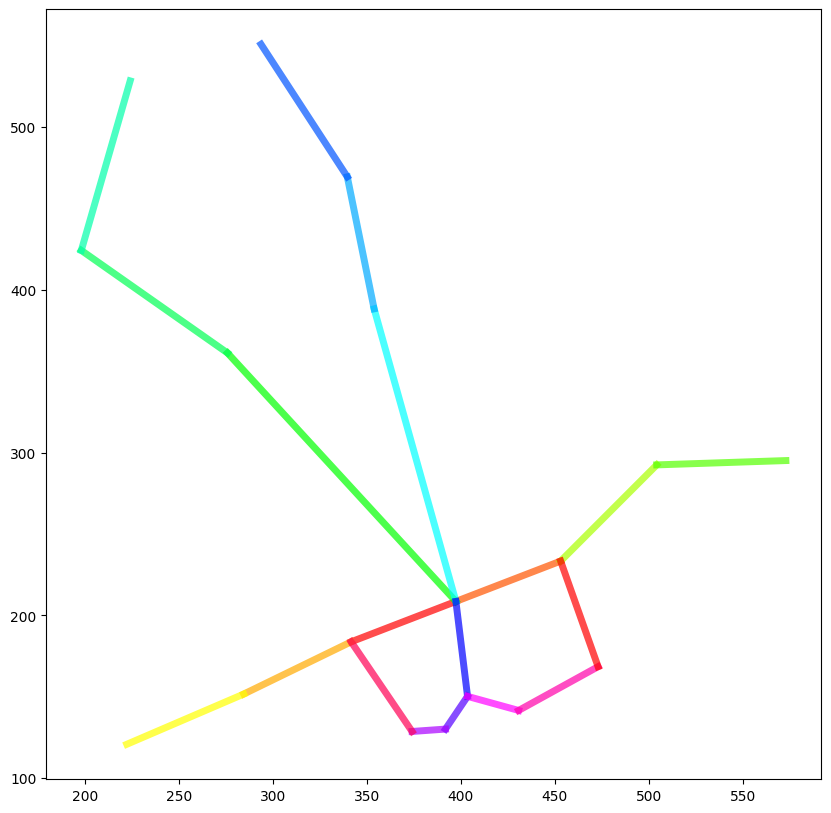

In [158]:
fig, ax = plt.subplots(1,1,figsize=(10,10))

plot_skel(df, df['video'].iloc[0],df['frame'].iloc[0],ax,'x','y',limbSeq,colors)

In [114]:
len(keypoints)

17

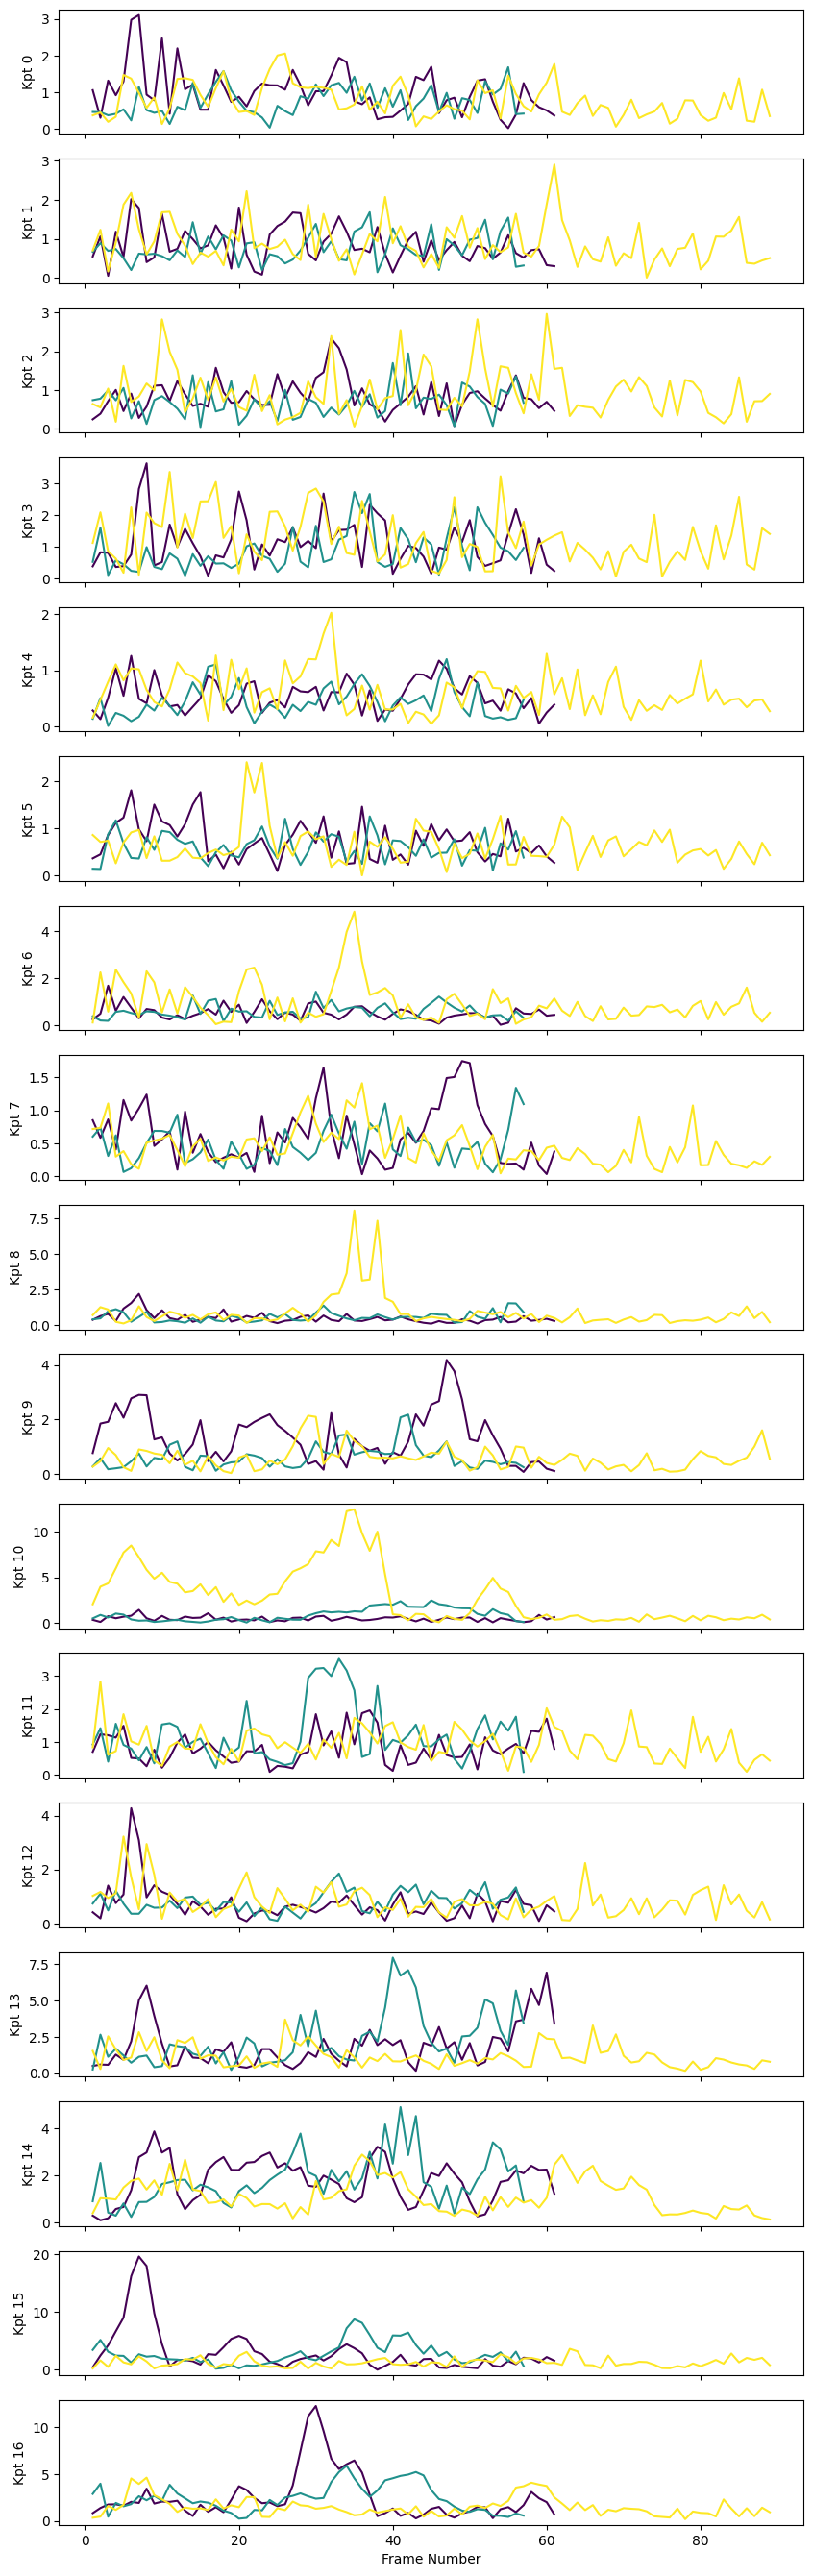

In [7]:
##look at displacement for each keypoint

def calculate_inter_frame_displacements(block):
    """
    Calculate the displacement of each keypoint between consecutive frames in a block.
    
    :param block: A list of frames, each frame is a dictionary with 'first_detection_keypoints'.
    :return: A list of numpy arrays, each array contains the displacements for a keypoint over time.
    """
    keypoints_array = np.array([frame['first_detection_keypoints'] for frame in block])
    displacements = np.diff(keypoints_array, axis=0)
    inter_frame_displacements = np.linalg.norm(displacements, axis=2)
    return inter_frame_displacements.T  # Transpose to have keypoints as rows


def plot_keypoint_displacements(displacements, block_id=0, axs=None, color=None):
    """
    Plot the inter-frame displacements for each keypoint on separate y-axes.
    
    :param displacements: A list of numpy arrays with displacements for each keypoint.
    :param block_id: Identifier for the block being plotted (for title).
    """
    num_keypoints = displacements.shape[0]
    num_frames = displacements.shape[1]
    
    # Create a figure and subplots
    
    
    # Plot each keypoint's displacement on its own subplot
    for i in range(num_keypoints):
        axs[i].plot(range(1, num_frames + 1), displacements[i], label=f'Keypoint {i}', color=color)
        axs[i].set_ylabel(f'Kpt {i}')
        #axs[i].legend(loc="upper right")
    
    plt.xlabel('Frame Number')
    #fig.suptitle(f'Inter-Frame Displacements for Block {block_id}')

num_keypoints = 17
fig, axs = plt.subplots(num_keypoints, 1, sharex=True, figsize=(10, 2 * num_keypoints))
color_range = plt.cm.viridis(np.linspace(0, 1, len(movement_blocks)))

for e, block in enumerate(movement_blocks):
    inter_frame_displacements = calculate_inter_frame_displacements(block)
    plot_keypoint_displacements(inter_frame_displacements, block_id=e, axs=axs, color=color_range[e])  

plt.show()  


In [108]:
def get_orig_dimensions(file):
    file_path = file  # change to your own video path
    vid = cv2.VideoCapture(file_path)
    height = vid.get(cv2.CAP_PROP_FRAME_HEIGHT)
    width = vid.get(cv2.CAP_PROP_FRAME_WIDTH)

    center_x = (width) / 2
    center_y = (height) / 2

    return width, height, center_x, center_y

def find_first_frame_center(block):

    first_frame = block[0]['first_detection_keypoints']
    first_frame = reorder_keypoints(first_frame, mapping)
    first_frame = np.array(first_frame)

    center_x = (first_frame[5][0] + first_frame[6][0]) / 2
    center_y = (first_frame[5][1] + first_frame[6][1]) / 2

    return center_x, center_y

def find_first_frame_rotation(block):
    first_frame = block[0]['first_detection_keypoints']
    first_frame = reorder_keypoints(first_frame, mapping)
    first_frame = np.array(first_frame)

    angle_to_vertical = np.arctan((first_frame[5][1] - first_frame[6][1]) / (first_frame[5][0] - first_frame[6][0]))

    return angle_to_vertical

def get_global_min_max(block):
    min_x, min_y = np.inf, np.inf  # Initialize min_x to positive infinity
    max_x, max_y = -np.inf, -np.inf  # Initialize max_x to negative infinity

    for e, frame in enumerate(block):
        frame_keypoints = np.array(frame['first_detection_keypoints'])

        min_x_frame, max_x_frame = np.min(frame_keypoints[:, 0]), np.max(frame_keypoints[:, 0])
        min_y_frame, max_y_frame = np.min(frame_keypoints[:, 1]), np.max(frame_keypoints[:, 1])

        min_x, max_x = min(min_x, min_x_frame), max(max_x, max_x_frame)
        min_y, max_y = min(min_y, min_y_frame), max(max_y, max_y_frame)

    return min_x, max_x, min_y, max_y

def adjust_bounds(block, x_dim, y_dim, displacement_x, displacement_y):
   # get the global min and max of the block
    min_x, max_x, min_y, max_y = get_global_min_max(block)
    
    new_min_x, new_max_x = (min_x + displacement_x), (max_x + displacement_x)
    new_min_y, new_max_y = (min_y + displacement_y), (max_y + displacement_y)

    if new_min_x < 0:
        displacement_x = displacement_x + np.abs(min_x)
    if new_min_y < 0:
        displacement_y = displacement_y + np.abs(min_y)

    if new_max_x >= x_dim:
        displacement_x = displacement_x - np.abs(new_max_x-x_dim)
    if new_max_y >=y_dim:
        displacement_y = displacement_y - np.abs(max_y-y_dim)

    return displacement_x, displacement_y

def get_block_displacement(block, image_center_x, image_center_y, x_dim, y_dim):
    
    block = np.array(block) 

    ## get the offset of the first frame keypoints from the center of the image
    center_x, center_y = find_first_frame_center(block)
    displacement_x = image_center_x - center_x
    displacement_y = image_center_y - center_y
    
    displacement_x, displacement_y = adjust_bounds(block, x_dim, y_dim, displacement_x, displacement_y)

    return displacement_x, displacement_y

def recenter_block (block, displacement_x, displacement_y):
    
    for e, frame in enumerate(block):
        if e == 0:
            print(f'adjusting block by {displacement_x}, {displacement_y}')

        frame_keypoints = np.array(block[e]['first_detection_keypoints'])
        frame_keypoints[:, 0] += displacement_x
        frame_keypoints[:, 1] += displacement_y

        block[e]['first_detection_keypoints'] = frame_keypoints.tolist()
    
    return block

def reorder_keypoints(keypoints, mapping):
    """
    Reorders the keypoints based on the mapping.
    
    :param new: List of keypoints to be reordered.
    :param mapping: Dictionary with the new index for each old index.
    :return: Reordered list of keypoints.
    """
    reordered = []
    reordered.extend([[0, 0] for i in range(len(keypoints) + 2)])
    
    reordered[1][0] = (keypoints[5][0]+keypoints[6][0])/2
    reordered[1][1] = (keypoints[5][1]+keypoints[6][1])/2

    reordered[8][0] = (keypoints[11][0]+keypoints[12][0])/2
    reordered[8][1] = (keypoints[11][1]+keypoints[12][1])/2
    
    # Ensure 'mapping' does not contain indices higher than 18.
    for old_index, new_index in mapping.items():
        try:
            reordered[new_index][0] = keypoints[old_index][0]
            reordered[new_index][1] = keypoints[old_index][1]
        except IndexError:
            print(f'{old_index, new_index} is out of range, skipping.')

    return reordered


def rotate_block(block):
    """
    Rotate keypoints by a given angle.
    
    :param keypoints: np.array of shape (N, 2) representing the keypoints.
    :param angle: Rotation angle in radians.
    :return: Rotated keypoints as np.array of shape (N, 2).
    """
    angle = find_first_frame_rotation(block)

    rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)],
                                [np.sin(angle),  np.cos(angle)]])
    
    # Rotate keypoints
    for e, frame in enumerate(block):
        if e == 0:
            print(f'rotating block by {angle}')

        frame_keypoints = np.array(block[e]['first_detection_keypoints'])
        frame_keypoints = np.dot(frame_keypoints, rotation_matrix)

        block[e]['first_detection_keypoints'] = frame_keypoints.tolist()
    
    return block


def normalize_skeleton(keypoints, frame_index=0):

    keypoints = reorder_keypoints(keypoints, mapping)
    keypoints = np.array(keypoints)


    return keypoints

def update_frame(frame_index, block, ax, limb_sequence, block_number):
    ax.clear()
    pose = block[frame_index]['first_detection_keypoints']
    pose_norm = normalize_skeleton(pose,frame_index=frame_index)

    x = pose_norm[:, 0]
    y = pose_norm[:, 1]

    skpt = []
    
    for j in range(len(pose_norm)):
        skpt.extend([x[j].astype(float),y[j].astype(float),2.0])   
    #skpt.extend([0,0,2,0,0,2])

    skpt_json_format = {"annotations": skpt}

    with open(os.path.join('/workspaces/wiggleformer/data/PANDA/test/test_frame_jsons', f'{block_number}_{frame_index}.json'), "w") as json_file:
        json.dump(skpt_json_format, json_file)

    plot_skeleton(pose_norm, limb_sequence, ax)
    #ax.set_xlim([-1, 1])
    #ax.set_ylim([0, 3])
    plt.axis('off')

    if not os.path.exists('/workspaces/wiggleformer/data/PANDA/test/test_frame_images'):
        os.makedirs('/workspaces/wiggleformer/data/PANDA/test/test_frame_images')

    plt.savefig(f'/workspaces/wiggleformer/data/PANDA/test/test_frame_images/{block_number}_{frame_index}.png')
    #ax.set_aspect('equal', adjustable='box')

def plot_skeleton(keypoints, limb_sequence, ax):
    keypoints = np.array(keypoints)
    
    x = keypoints[:, 0]
    y = keypoints[:, 1]
    for i, limb in enumerate(limb_sequence):
        start_idx, end_idx = limb
        ax.plot([x[start_idx], x[end_idx]], [y[start_idx], y[end_idx]], linewidth=5, color=[j/255 for j in colors[i]], alpha=alpha)
    for i in range(len(keypoints)):
        ax.plot(x[i], y[i], 'o', markersize=10, color=[j/255 for j in colors[i]], alpha=alpha)

def animate_good_block(block, limb_sequence, block_number):
    dpi = 90
    x_dim, y_dim = get_orig_dimensions('/workspaces/wiggleformer/data/PANDA/test/video/test_clip.mp4')
    fig, ax = plt.subplots()
    fig.set_size_inches(x_dim/dpi, y_dim/dpi)
    fig.set_dpi(dpi)

    ani = FuncAnimation(fig, update_frame, frames=range(len(block)), fargs=(block, ax, limb_sequence, block_number), interval=100)
    return ani

# Example usage


1920.0 1080.0
adjusting block by 0.0, 0.0


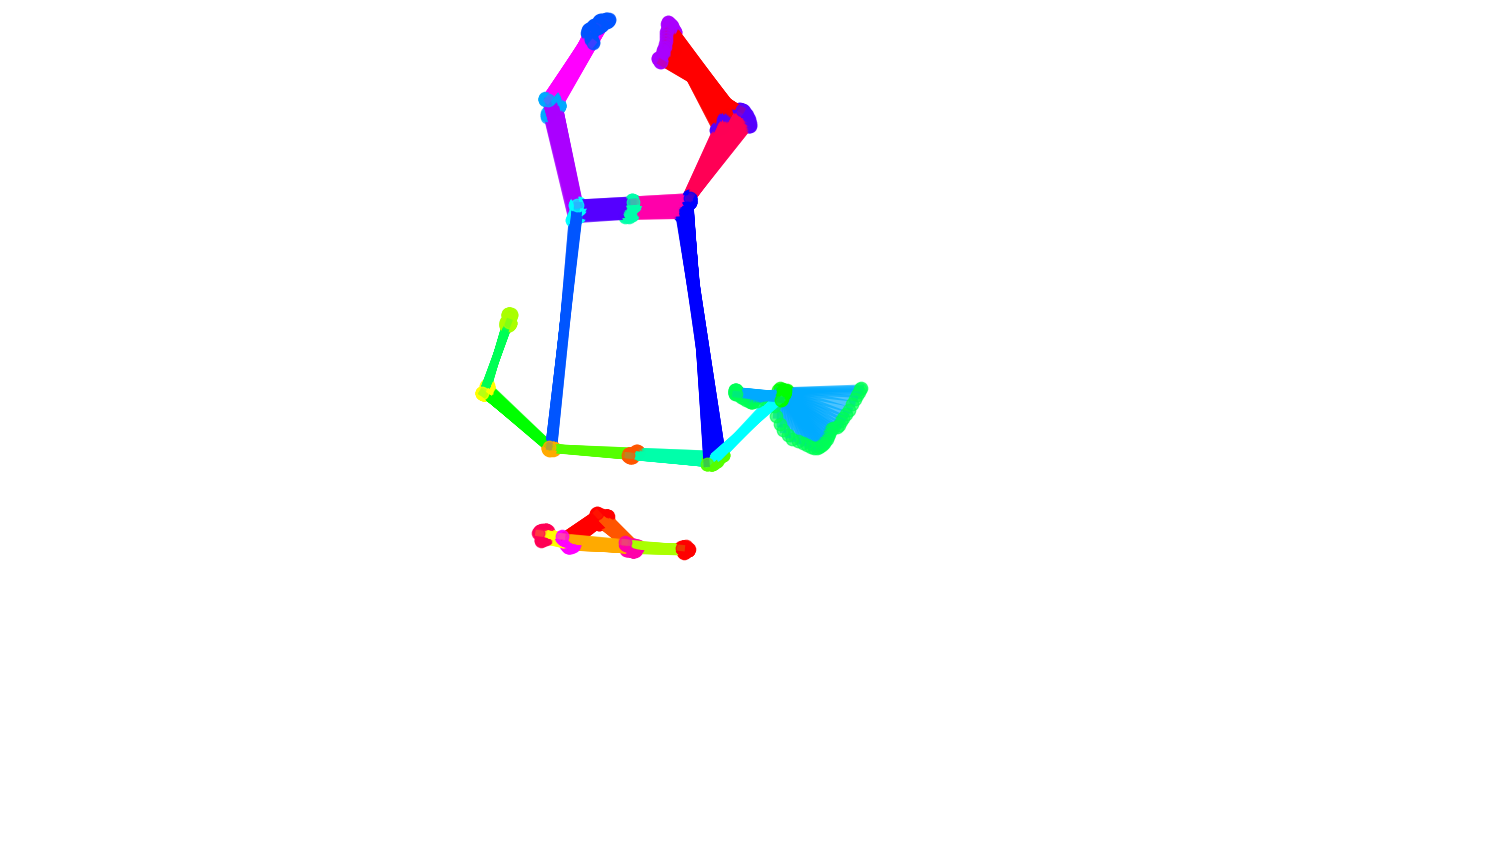

In [50]:
# Assuming `good_blocks` is a list of good blocks
dpi = 90
alpha = 0.7

fig = plt.figure()
ax = plt.gca()
x_dim, y_dim, x_center, y_center = get_orig_dimensions('/workspaces/wiggleformer/data/PANDA/test/video/test_clip.mp4')

print(x_dim, y_dim)
ax.set_xlim([0, x_dim])
ax.set_ylim([0, y_dim])
ax.invert_yaxis()
ax.axis('off')

fig.set_size_inches(x_dim/dpi, y_dim/dpi)
fig.set_dpi(dpi)


### 
"""
for each movement block, get the displacement of the first frame
check if the displacement will make any x or y value in any frame go out of bounds
if so, adjust the displacement accordingly
return the displacement parameters 
recenter all the blocks using the displacement parameters

"""



for i, block in enumerate(movement_blocks[2:3]):          
    
    block = rotate_block(block)
    displacement_x, displacement_y = get_block_displacement(block, x_center, y_center, x_dim, y_dim)
    #ani = animate_good_block(block, limb_sequence, block_number=i)  
    #ani.save(f'animation_{i}.mp4', writer='ffmpeg', codec='mpeg4')
    block = recenter_block(block, displacement_x, displacement_y)
    
    for i, frame in enumerate(block):
        pose = block[i]['first_detection_keypoints']
        pose_norm = normalize_skeleton(pose)

        kpts = plot_skeleton(pose_norm, limb_sequence, ax)


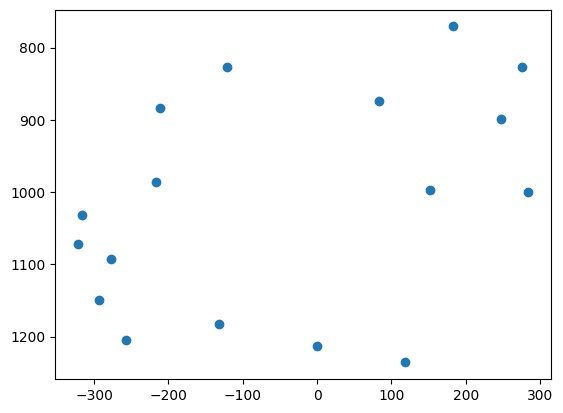

In [100]:
ang = np.arctan2(pose[8][0], pose[8][1])
center = (np.array(pose[8]) + np.array(pose[1]))/2
keypoints = [[0 + pose[i][0]*np.cos(ang) - pose[i][1]*np.sin(ang), 0 + pose[i][0]*np.sin(ang) + pose[i][1]*np.cos(ang)] for i in range(len(pose)) ]
#keypoints = [[keypoints[i][0] - center[0], keypoints[i][1] - center[1]] for i in range(len(keypoints))]

fig, ax = plt.subplots()
ax.invert_yaxis()
plt.scatter(np.array(keypoints)[:,0],np.array(keypoints)[:,1])

<function matplotlib.pyplot.show(close=None, block=None)>

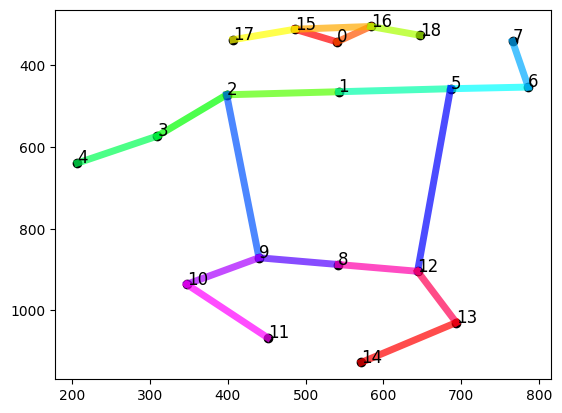

In [43]:
colors_openpose = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0],
          [0, 255, 0], \
          [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255],
          [85, 0, 255], \
          [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85],[255, 0, 0]]

orig = [
540.3536987304688, 342.3381652832031, 2.0, 
542.3785705566406, 464.4452209472656, 2.0, 
398.61273193359375, 471.8660888671875, 2.0, 
309.51837158203125, 573.059814453125, 2.0, 
206.92486572265625, 639.1730346679688, 2.0, 
686.1444091796875, 457.02435302734375, 2.0, 
786.0380859375, 452.9765930175781, 2.0, 
765.789306640625, 340.9889221191406, 2.0, 
541.9588297041303, 887.6578947368421, 2.0, 
440.11672444097235, 871.078947368421, 2.0, 
347.3159484863281, 936.0078125, 2.0, 
451.25933837890625, 1066.885009765625, 2.0, 
643.8009349672882, 904.2368421052631, 2.0, 
693.5377770725513, 1029.7631578947369, 2.0, 
571.4017333984375, 1127.6011962890625, 2.0, 
486.35711669921875, 311.3054504394531, 2.0, 
583.5509643554688, 304.5592041015625, 2.0, 
406.7121887207031, 336.941162109375, 2.0, 
646.9968872070312, 326.1471862792969, 2.0]

x = orig[::3]
y = orig[1::3]

limbSeq_openpose = [[0,15],[0,16],[15,16],[15,17],[16,18],[1,2],[2,3],[3,4],[1,5],[5,6],[6,7],[2,9],[5,12],[8,9],[9,10],[10,11],[8,12],[12,13],[13,14]]

fig, ax = plt.subplots()

ax.invert_yaxis()

for i, limb in enumerate(limbSeq_openpose):
       start_idx, end_idx = limb
       ax.plot([x[start_idx], x[end_idx]], [y[start_idx], y[end_idx]], linewidth=5, color=[j/255 for j in colors_openpose[i]], alpha=alpha)

# Annotating each node with its number
for i in range(len(x)):
    ax.text(x[i], y[i], str(i), color='black', fontsize=12)

ax.scatter(x, y, color='black')
plt.show

In [ ]:
mapping = {0:0,1:15,2:16,3:17,4:18,5:2,6:5,7:3,8:6,9:4,10:7,11:9,12:12,13:10,14:13,15:11,16:14,17:17,18:18}

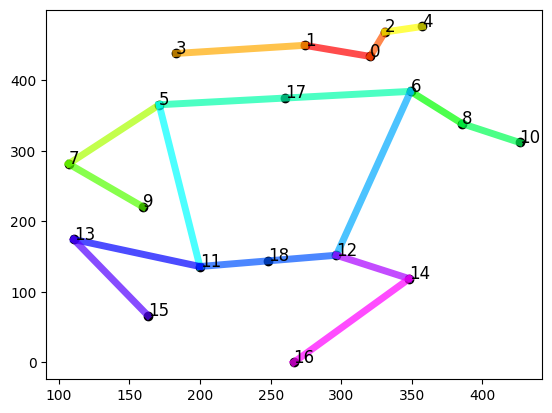

In [112]:
mapping = {0:0,1:15,2:16,3:17,4:18,5:2,6:5,7:3,8:6,9:4,10:7,11:9,12:12,13:10,14:13,15:11,16:14, 17:1, 18:8}

new = [320.50829107033337, 433.67906792050724, 2.0, 
       274.1088263974856, 449.43478431734854, 2.0, 
       330.9267882971945, 468.3157080128923, 2.0, 
       182.85167823210918, 437.8879811881567, 2.0, 
       357.59422791013975, 476.12261263294806, 2.0, 
       171.02284494584126, 365.1858283040423, 2.0, 
       349.1798307782122, 384.1887028336272, 2.0, 
       106.88257222489528, 281.48226430901593, 2.0, 
       385.76217541370863, 338.38431838869735, 2.0, 
       159.65307815993583, 220.35466777669023, 2.0, 
       426.36923733174285, 311.7680972331101, 2.0, 
       199.86674724556462, 135.99158458729664, 2.0, 
       296.5669342497698, 151.9616892276008, 2.0, 
       110.49486961596301, 174.3002588871683, 2.0, 
       348.242014805116, 118.76372336422025, 2.0, 
       163.04151219676373, 66.44034328851353, 2.0, 
       266.2557857576525, 0.0, 2.0,
       0,0,2,
       0,0,2]

new[17*3] = (new[5*3]+new[6*3])/2
new[17*3+1] = (new[5*3+1]+new[6*3+1])/2

new[18*3] = (new[11*3]+new[12*3])/2
new[18*3+1] = (new[11*3+1]+new[12*3+1])/2

x = new[::3]
y = new[1::3]

for i,limb in enumerate(limb_sequence):
    
    start_idx, end_idx = limb
    plt.plot([x[start_idx], x[end_idx]], [y[start_idx], y[end_idx]],linewidth=5, color=[j/255 for j in colors_openpose[i]], alpha=alpha)

plt.scatter(new[::3], new[1::3], color='black')
for i in range(len(x)):
    plt.text(new[::3][i], new[1::3][i], str(i), color='black', fontsize=12)

plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

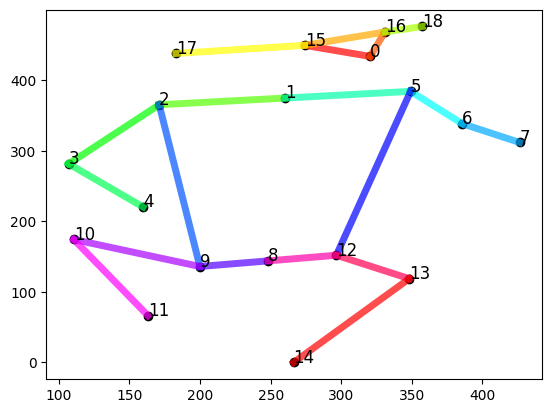

In [114]:
limbSeq_openpose = [[0,15],[0,16],[15,16],[15,17],[16,18],[1,2],[2,3],[3,4],[1,5],[5,6],[6,7],[2,9],[5,12],[8,9],[9,10],[10,11],[8,12],[12,13],[13,14]]

def reorder_keypoints(new, mapping):
    """
    Reorders the keypoints based on the mapping.
    
    :param new: List of keypoints to be reordered.
    :param mapping: Dictionary with the new index for each old index.
    :return: Reordered list of keypoints.
    """
    reordered = [0] * len(new)  # Create a list with the same length as 'new'

    for old_index, new_index in mapping.items():
        # Multiply by 3 since each keypoint consists of 3 values (x, y, and a score)
        old_position = old_index * 3
        new_position = new_index * 3

        reordered[new_position:new_position+3] = new[old_position:old_position+3]
    
    return reordered

# Reorder the list based on the mapping
reordered = [0] * len(new)  # Create a list with the same length as 'new'

for old_index, new_index in mapping.items():
    # Multiply by 3 since each keypoint consists of 3 values (x, y, and a score)
    old_position = old_index * 3
    new_position = new_index * 3

    reordered[new_position:new_position+3] = new[old_position:old_position+3]

x = reordered[::3]
y = reordered[1::3]

fig, ax = plt.subplots()

for i, limb in enumerate(limbSeq_openpose):
       start_idx, end_idx = limb
       ax.plot([x[start_idx], x[end_idx]], [y[start_idx], y[end_idx]], linewidth=5, color=[j/255 for j in colors_openpose[i]], alpha=alpha)

for i in range(len(x)):
    ax.text(x[i], y[i], str(i), color='black', fontsize=12)

ax.scatter(x, y, color='black')
plt.show